## Задание: Факторный анализ
### Анализ удовлетворенности путешественников

С помощью метода главных компонент проанализируйте данные и постарайтесь ответить на вопрос соревнования,
что влияет на удовлетворенность путешественников.
Данные взяты отсюда
https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction/tasks

Данные представляют собой результаты анкетирования более 100 тысяч путешественников на предмет их удовлетворенностью полетом. Помимо параметров описывающих условия полета, еще есть информация об уровне удовлетворенности (satisfaction). Ваша задача выделить группу переменных, которые иммет смысл оъединить в факторы. Дать какое-то содержательное название этим факторам (например комфорт на борту или другие). Полностью провести факторный анализ, сделать выводы.  затем построить регрессионную модель для оценки удовлетворенности путешественников с использованием новых факторов и протестировать ее на внешней выборке (тестовых данных)

In [ ]:
#!pip install pingouin
#!pip install factor-analyzer

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
from statsmodels.formula.api import ols, glm, logit
#если нет этой библиотеки то pip install factor-analyzer или локально через конду conda install -c desilinguist factor_analyzer
from factor_analyzer import FactorAnalyzer
from factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from statsmodels.stats.outliers_influence import variance_inflation_factor
np.set_printoptions(suppress=True)
%matplotlib inline

In [ ]:
#path = '/Users/irinaknyazeva/Projects/Edu/MachineLearning/ML2020/assignments/datasets/'
#train_airline = pd.read_csv(path+'airline_train.csv.zip', index_col = 0)
link_train = 'https://github.com/iknyazeva/ML2020/raw/master/assignments/datasets/airline_train.csv.zip'
link_test = 'https://github.com/iknyazeva/ML2020/raw/master/assignments/datasets/airline_test.csv.zip'
train_airline = pd.read_csv(link_train, index_col = 0)


In [ ]:
train_airline.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied


In [ ]:
train_airline.shape

(103904, 24)

In [ ]:
train_airline.satisfaction.value_counts()

neutral or dissatisfied    58879
satisfied                  45025
Name: satisfaction, dtype: int64

In [ ]:
train_airline['Class'] = pd.Categorical(train_airline['Class']).codes
train_airline['Customer Type'] = pd.Categorical(train_airline['Customer Type']).codes
train_airline['Gender'] = pd.Categorical(train_airline['Gender']).codes
train_airline['Type of Travel'] = pd.Categorical(train_airline['Type of Travel']).codes
train_airline['satisfaction'] = pd.Categorical(train_airline['satisfaction']).codes

In [ ]:
train_airline.drop(['Trave', 'Type of Trave'], axis='columns', inplace=True)

In [ ]:
train_airline.head()


,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,1,0,13,1,2,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,0
1,5047,1,1,25,0,0,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,0
2,110028,0,0,26,0,0,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,1
3,24026,0,0,25,0,0,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,0
4,119299,1,0,61,0,0,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,1


## Визуальный и описательный анализ
Посчитайте статистики по данным которые посчитаете интересными. Визуализируйте корреляционную матрицу признаков, опишите ваши наблюдения.

In [ ]:
print(train_airline.Gender.value_counts())

Female    52727
Male      51177
Name: Gender, dtype: int64


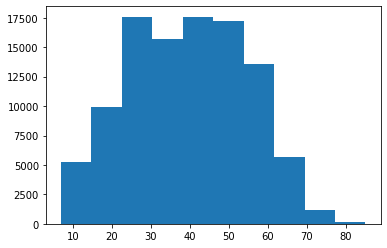

In [ ]:
plt.hist(train_airline['Age'])
plt.show()

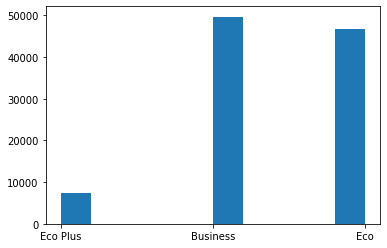

In [ ]:
plt.hist(train_airline['Type of Travel'])
plt.show()

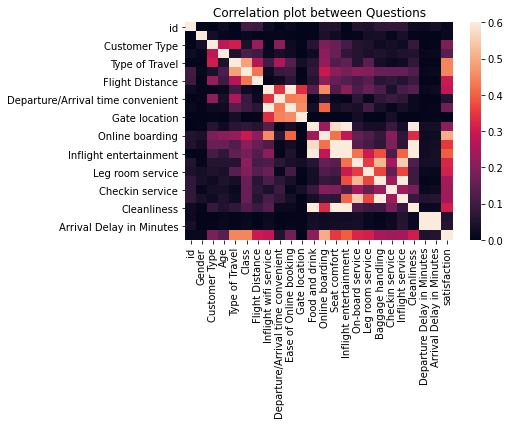

In [ ]:
c= train_airline.corr()
sns.heatmap(np.abs(c), vmin=0, vmax=0.6); plt.title('Correlation plot between Questions');

Как мы можем заметить, есть несколько вопросов, которые в основном не коррелируют с другими, их не так уж много, например, задержка отправления и прилета. При этом мы можем заметить несколько зон в центре, которые демонстрируют, что есть переменные сильно коррелирующие с другими, например, чистота, которая сильно коррелирует с развлечениями на борту, едой и комфортом. Это показывает нам потенциальную возможность создания факторов. 

Давайте расчитаем VIF для наших переменных, чтобы убедиться, что мы не можем использовать их в линейной модели по отдельности из-за мультиколлинеарности

## Факторный анализ

In [ ]:
numcol = ['Inflight wifi service', 'Food and drink', 'Ease of Online booking', 'Departure/Arrival time convenient', 'Gate location', 'Seat comfort',	'Inflight entertainment',	'On-board service',	'Leg room service',	'Baggage handling',	'Checkin service',	'Inflight service',	'Cleanliness', 'Class', 'Customer Type', 'Gender', 'Type of Travel', 'Flight Distance', 'Online boarding', 'satisfaction']
df = train_airline[numcol]

In [ ]:
vif = pd.DataFrame()
vif["variables"] = df.columns
vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
vif

,variables,VIF
0,Inflight wifi service,13.104680
1,Food and drink,14.114831
2,Ease of Online booking,13.313317
3,Departure/Arrival time convenient,8.402541
4,Gate location,8.827829
5,Seat comfort,18.041382
6,Inflight entertainment,27.615626
7,On-board service,13.828373
8,Leg room service,9.443332
9,Baggage handling,19.332987


Из переменных, которые не зависят от других мы выделяем: Пол, Тип полета, Расстояние полета, Класс и Тип клиента. По показателям VIF остальные переменные показывают высокую мультиколлинеарность, значение выше или около 10. 

In [ ]:
calculate_bartlett_sphericity(df)

(812893.2722438675, 0.0)

Так как p-val равнеется нуля отвергает нулевую гипотезу о том, что наши переменные независимы.

Отибраем зависимые переменные в отдельный датафрейм

In [ ]:
factor = ['Inflight wifi service', 'Food and drink', 'Ease of Online booking', 'Departure/Arrival time convenient', 'Gate location', 'Seat comfort',	'Inflight entertainment',	'On-board service',	'Leg room service',	'Baggage handling',	'Checkin service',	'Inflight service',	'Cleanliness', 'Online boarding']

In [ ]:
df_factors=df[factor]
df_factors.head()

,Inflight wifi service,Food and drink,Ease of Online booking,Departure/Arrival time convenient,Gate location,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Online boarding
0,3,5,3,4,1,5,5,4,3,4,4,5,5,3
1,3,1,3,2,3,1,1,1,5,3,1,4,1,3
2,2,5,2,2,2,5,5,4,3,4,4,4,5,5
3,2,2,5,5,5,2,2,2,5,3,1,4,2,2
4,3,4,3,3,3,5,3,3,4,4,3,3,3,5


First 5 values of eiegenvalues [3.80011677 2.36198598 2.16589224 1.06327401 0.95093123]


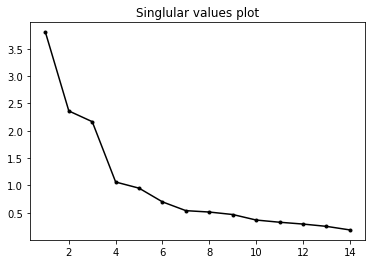

In [ ]:
fa = FactorAnalyzer()
fa.fit(df_factors)
ev, v = fa.get_eigenvalues()
plt.plot(range(1,df_factors.shape[1]+1),ev,'.-k'); plt.title('Singlular values plot')
print('First 5 values of eiegenvalues', ev[:5])


По критерию Кайзера у нас выделяются 4 фактора, у которые значение собственного числа больше еденицы

In [ ]:
fa = FactorAnalyzer(4, rotation='varimax')
fa.fit(df_factors)
loads = fa.loadings_
colnames = ['f1','f2','f3','f4']
df_loads = pd.DataFrame(loads, columns = ['f1','f2','f3','f4'])
df_loads['airline'] = df_factors.keys()
for col in colnames:
    df_loads['abs'+col] = np.abs(df_loads[col])
df_loads.sort_values(by=['absf3'], ascending=False )[colnames+['airline']]

,f1,f2,f3,f4,airline
2,-0.036124,0.027503,0.766509,0.463396,Ease of Online booking
4,0.013097,-0.045142,0.680813,-0.100044,Gate location
0,0.092606,0.132303,0.605630,0.478035,Inflight wifi service
3,-0.006287,0.057166,0.589643,0.000283,Departure/Arrival time convenient
13,0.286895,0.118512,0.094301,0.756382,Online boarding
9,0.036738,0.763384,0.047617,-0.030583,Baggage handling
11,0.035962,0.799641,0.047595,-0.051573,Inflight service
6,0.766237,0.464666,0.041222,0.032708,Inflight entertainment
8,0.057541,0.483208,0.040559,0.097485,Leg room service
1,0.770130,0.002845,0.032987,0.040034,Food and drink


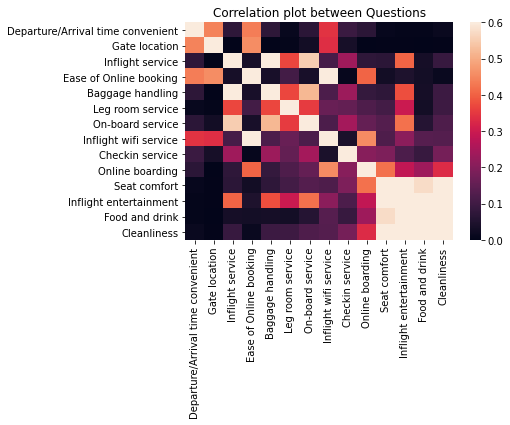

In [ ]:
idxs = np.argsort(df_loads['absf1']).values
corr_array = df_factors.corr()
sns.heatmap(np.abs(corr_array.iloc[idxs, :].T.iloc[idxs, :]), vmin=0, vmax=0.6); plt.title('Correlation plot between Questions');

Видим, что после перегруппировки появилось пятно корреляций в нижнем углу матрицы

In [ ]:
print(df_loads.sort_values(by=['absf1'], ascending=False )[['f1','airline']].head(5))
Q_f_stats = df_loads.sort_values(by=['absf1'], ascending=False )['airline'].values[:5]
print(Q_f_stats) 
comfort_on_b = df_factors.loc[:,Q_f_stats]
comfort_on_b.head()
print(f'Согласованность переменных в факторе комфорт на борту: {pg.cronbach_alpha(fear_of_stats)}, 1 в идеальном варианте')

          f1                 airline
12  0.854326             Cleanliness
1   0.770130          Food and drink
6   0.766237  Inflight entertainment
5   0.754094            Seat comfort
13  0.286895         Online boarding
['Cleanliness' 'Food and drink' 'Inflight entertainment' 'Seat comfort'
 'Online boarding']
Согласованность переменных в факторе комфорт на борту: (0.7713577920728945, array([0.769, 0.773])), 1 в идеальном варианте


Достаточно хороший результат (0,77), больше 0,6

In [ ]:
print(df_loads.sort_values(by=['absf2'], ascending=False )[['f2','airline']].head(5))
Q_f_stats = df_loads.sort_values(by=['absf2'], ascending=False )['airline'].values[:5]
print(Q_f_stats) 
service = df_factors.loc[:,Q_f_stats]
service.head()
print(f'Согласованность переменных в факторе сервис: {pg.cronbach_alpha(service)}, 1 в идеальном варианте')

          f2                 airline
11  0.799641        Inflight service
9   0.763384        Baggage handling
7   0.700438        On-board service
8   0.483208        Leg room service
6   0.464666  Inflight entertainment
['Inflight service' 'Baggage handling' 'On-board service'
 'Leg room service' 'Inflight entertainment']
Согласованность переменных в факторе сервис: (0.7856489553874129, array([0.784, 0.788])), 1 в идеальном варианте


In [ ]:
print(df_loads.sort_values(by=['absf3'], ascending=False )[['f3','airline']].head(5))
Q_f_stats = df_loads.sort_values(by=['absf3'], ascending=False )['airline'].values[:5]
print(Q_f_stats) 
before_fly = df_factors.loc[:,Q_f_stats]
before_fly.head()
print(f'Согласованность переменных в факторе удобность процесса до полета: {pg.cronbach_alpha(before_fly)}, 1 в идеальном варианте')

          f3                            airline
2   0.766509             Ease of Online booking
4   0.680813                      Gate location
0   0.605630              Inflight wifi service
3   0.589643  Departure/Arrival time convenient
13  0.094301                    Online boarding
['Ease of Online booking' 'Gate location' 'Inflight wifi service'
 'Departure/Arrival time convenient' 'Online boarding']
Согласованность переменных в факторе удобность процесса до полета: (0.7422763190291576, array([0.74 , 0.745])), 1 в идеальном варианте


In [ ]:
print(df_loads.sort_values(by=['absf4'], ascending=False )[['f4','airline']].head(3))
Q_f_stats = df_loads.sort_values(by=['absf4'], ascending=False )['airline'].values[:3]
print(Q_f_stats) 
internet = df_factors.loc[:,Q_f_stats]
internet.head()
print(f'Согласованность переменных в факторе интернет: {pg.cronbach_alpha(internet)}, 1 в идеальном варианте')

          f4                 airline
13  0.756382         Online boarding
0   0.478035   Inflight wifi service
2   0.463396  Ease of Online booking
['Online boarding' 'Inflight wifi service' 'Ease of Online booking']
Согласованность переменных в факторе интернет: (0.7685805890788289, array([0.766, 0.771])), 1 в идеальном варианте


## Логистическая регрессия
Но вместо группы переменных, которые вы выбрали - используем факторы

In [ ]:
log = pd.DataFrame(fa.transform(df_factors),columns = ['f1','f2','f3','f4'])
log['satisfaction'] = train_airline['satisfaction']
log ['Age'] = train_airline['Age']
log['Class'] = train_airline['Class']
log.head()

,f1,f2,f3,f4,satisfaction,Age,Class
0,1.239017,0.643487,-0.114692,-0.060921,0,13,2
1,-1.950791,-0.440574,-0.053294,0.286890,0,25,0
2,1.369356,0.335665,-0.922205,0.577786,1,26,0
3,-1.105765,-0.383531,1.597348,-0.614574,0,25,0
4,0.171095,-0.260457,-0.183430,1.016513,1,61,0


In [ ]:
model = logit('satisfaction ~ f1', data = log).fit()
print(model.summary())
print(np.exp(model.conf_int()))

Optimization terminated successfully.
         Current function value: 0.636461
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           satisfaction   No. Observations:               103904
Model:                          Logit   Df Residuals:                   103902
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Jan 2021   Pseudo R-squ.:                 0.06982
Time:                        17:01:19   Log-Likelihood:                -66131.
converged:                       True   LL-Null:                       -71094.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3062      0.007    -46.240      0.000      -0.319      -0.293
f1             0.7185      0.

LLR p-value равняется нуля,  Pseudo R-squ очень маленький, что не позволяет говорит о сильном влияние первого фактора. Хотя его p-value говорит о том, что он статестически значим

In [ ]:
model = logit('satisfaction ~ f2', data = log).fit()
print(model.summary())
print(np.exp(model.conf_int()))

Optimization terminated successfully.
         Current function value: 0.621396
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           satisfaction   No. Observations:               103904
Model:                          Logit   Df Residuals:                   103902
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Jan 2021   Pseudo R-squ.:                 0.09183
Time:                        17:02:15   Log-Likelihood:                -64565.
converged:                       True   LL-Null:                       -71094.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3210      0.007    -47.579      0.000      -0.334      -0.308
f2             0.8722      0.

In [ ]:
model = logit('satisfaction ~ f3', data = log).fit()
print(model.summary())
print(np.exp(model.conf_int()))

Optimization terminated successfully.
         Current function value: 0.683780
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:           satisfaction   No. Observations:               103904
Model:                          Logit   Df Residuals:                   103902
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Jan 2021   Pseudo R-squ.:               0.0006598
Time:                        17:02:20   Log-Likelihood:                -71047.
converged:                       True   LL-Null:                       -71094.
Covariance Type:            nonrobust   LLR p-value:                 3.451e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2685      0.006    -42.869      0.000      -0.281      -0.256
f3             0.0681      0.

У этой модели очень маленький Pseudo R-squ

In [ ]:
model = logit('satisfaction ~ f4', data = log).fit()
print(model.summary())
print(np.exp(model.conf_int()))

Optimization terminated successfully.
         Current function value: 0.585957
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           satisfaction   No. Observations:               103904
Model:                          Logit   Df Residuals:                   103902
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Jan 2021   Pseudo R-squ.:                  0.1436
Time:                        17:02:23   Log-Likelihood:                -60883.
converged:                       True   LL-Null:                       -71094.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3721      0.007    -52.325      0.000      -0.386      -0.358
f4             1.2855      0.

In [ ]:
model = logit('satisfaction ~ f1+f2+f3+f4', data = log).fit()
print(model.summary())
print(np.exp(model.conf_int()))

Optimization terminated successfully.
         Current function value: 0.469563
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           satisfaction   No. Observations:               103904
Model:                          Logit   Df Residuals:                   103899
Method:                           MLE   Df Model:                            4
Date:                Mon, 04 Jan 2021   Pseudo R-squ.:                  0.3137
Time:                        16:57:57   Log-Likelihood:                -48790.
converged:                       True   LL-Null:                       -71094.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4772      0.008    -57.742      0.000      -0.493      -0.461
f1             0.8257      0.

Эта модель удачнее двух построенных раннее, Log-Likelihood ближе к нулю. Выше Pseudo R-squ. Все факторы оказались значимыми. 